In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats 
 
import matplotlib_inline 
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

import torch 
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split


In [2]:
# import the data
url  = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
data = pd.read_csv(url,sep=',',header=None)
data.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','DISEASE']


# data contain some ?'s; replace with NaN and drop those rows
data = data.replace('?',np.nan).dropna()

# z-score the non-categorical columns
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop(['sex','fbs','exang','DISEASE'])

for c in cols2zscore:
  d = pd.to_numeric(data[c]) # force to numeric (addresses some data-format issues)
  data[c] = (d - d.mean())/d.std(ddof=1)

In [3]:
# # removing outliers
# data = data[~(data['trestbps'] > 2)]
# data = data[~(data['chol'] > 2)]
# data = data[~(data['oldpeak'] > 2)]

In [4]:
# re-code events to 0 (absent) and 1 (present)
data.loc[data['DISEASE'] > 0, 'DISEASE'] = 1

In [5]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[data.keys().drop('DISEASE')].values ).float()
labelsT = torch.tensor( data['DISEASE'].values ).float()

print( dataT.shape )
print( labelsT.shape )

# we'll actually need the labels to be a "matrix"
labelsT = labelsT[:,None]
print( labelsT.shape )

torch.Size([297, 13])
torch.Size([297])
torch.Size([297, 1])


In [6]:

# splitting data 
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size = 50)

# converting into tensor dataset
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

# creating dataloaders 
train_loader = DataLoader(train_dataset, batch_size = 20, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = test_dataset.tensors[0].shape[0])


In [46]:
def CreateNeuralNet():

    class NeuralNet(nn.Module):

        def __init__(self):
            super().__init__()



            # input layer 
            self.input = nn.Linear(13, 32)

            # hidden layers 
            
            self.hidden1 = nn.Linear(32, 64)
            self.hidden2 = nn.Linear(64, 128)
            self.hidden3 = nn.Linear(128, 16)
    

            
            # output layer
            self.output = nn.Linear(16, 1)


        def forward(self, X):

            # input layer 
            X = F.relu(self.input(X))
            

            # hidden layers
            X = F.relu(self.hidden1(X)) 
            X = F.relu(self.hidden2(X))  
            X = F.relu(self.hidden3(X))     
            

            # output layer 
            return self.output(X)



    net = NeuralNet()

    optimizer = torch.optim.Adam(net.parameters(), lr = .0009)
    # loss function 
    lossfun = nn.BCEWithLogitsLoss()


    return net, lossfun, optimizer 

            

In [47]:
def trainModel():

    # training epochs 
    numepochs = 50

    # getting the net ,loss function and optimizer 
    net, lossfun, optimizer = CreateNeuralNet()

    losses = np.zeros(numepochs)
    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):

        net.train()
        batchAcc = []
        batchLoss = []

        for X, y in train_loader:
            
            # forward pass 
            yHat = net(X)
            # loss
            loss = lossfun(yHat, y)

            optimizer.zero_grad()
            # back prop
            loss.backward()
            # update 
            optimizer.step()


            ### Accuracy calculation 
            matches = ((yHat > 0).float() == y).float()
            accuracy = 100 * torch.mean(matches)
            batchAcc.append(accuracy)

            batchLoss.append(loss.item())

        trainAcc.append(np.mean(batchAcc))
        losses[epochi] = np.mean(batchLoss)

        net.eval()
        X, y = next(iter(test_loader))
        with torch.inference_mode():

            yHat = net(X)
            ### Accuracy calculation 
            matches = ((yHat > 0).float() == y).float()
            accuracy = 100 * torch.mean(matches)
            testAcc.append(accuracy)

    return trainAcc, testAcc, losses, net



    

In [48]:
trainAcc, testAcc, losses, net = trainModel()

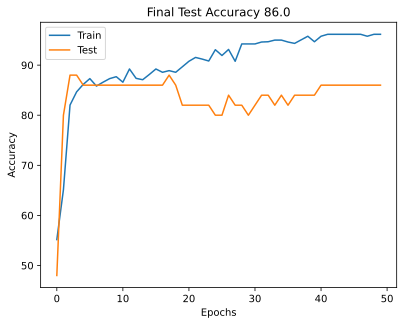

In [49]:
plt.plot(trainAcc, label = 'Train')
plt.plot(testAcc, label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(f'Final Test Accuracy {testAcc[-1]}')
plt.legend()
plt.show()

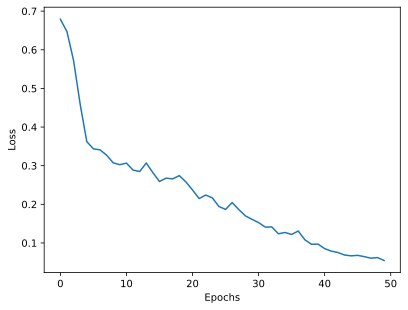

In [50]:
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [51]:
test = 0
for i in range(10):
    trainAcc, testAcc, losses, net = trainModel()
    test += testAcc[-1]
    print(trainAcc[-1], testAcc[-1])

print(test/10)

98.90109 tensor(80.)
99.23077 tensor(86.)
100.0 tensor(80.)
99.61539 tensor(78.)
100.0 tensor(82.)
99.23077 tensor(82.)
99.23077 tensor(82.)
99.23077 tensor(86.)
99.61539 tensor(84.)
100.0 tensor(86.)
tensor(82.6000)


In [13]:
losses[-1]

0.00043980751629882993

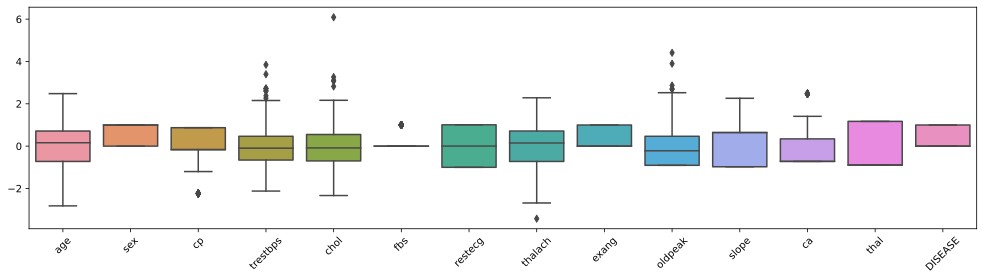

In [14]:
# check the distributions again
fig,ax = plt.subplots(1,figsize=(17,4))
ax = sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [15]:
data.shape

(297, 14)